EfficientNetB4 Model 

    Best model for Food 101 Image recognition:

    Learning_Rate    No.of Epochs  Training_Accuracy  Test_accuracy 
  	  4e-3              3            0.85               0.89
	    2e-4              5            0.89               0.91 (22952/25250) After Manual cleaning + TTA (Test Time Augmentation) + Optimized leaning rate

    With just 5 epochs we are able to achieve state of the art results as mentioned ih the EfficientNet paper. 
    If we were to train this model for more number of epochs we can achieve higher accuracies too for food recognition. 
           



In [ ]:
# cheking the number of cored this system has.
!cat /proc/cpuinfo | grep "cpu cores" | uniq

# GPU info
!nvidia-smi

# Amount of system RAM available to be used.
from psutil import virtual_memory
ram_gb = virtual_memory().total / (1024 * 1024 * 1024)   
print('Your runtime has {:.1f} gigabyte of availabe\n'.format(ram_gb))

#finding the recursion limit to avoid Augmentation recursion error 
import sys
print(sys.getrecursionlimit())

#installing fastai
!pip install torch===1.4.0 torchvision===0.5.0 -f https://download.pytorch.org/whl/torch_stable.html

cpu cores	: 2
Sat May 15 05:55:40 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.19.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   48C    P0    29W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                          

In [ ]:
#importing libraries and initializing fastai 
import pandas as pd 
import numpy as np 
import time

#Mounting google drive for saving the models after training 
from google.colab import drive
drive.mount('/content/drive')

from fastai.vision import *
from fastai.metrics import error_rate

Mounted at /content/drive


In [ ]:
#Installing the pytorch Implementation of EfficientNet 
!pip install --upgrade efficientnet-pytorch

from efficientnet_pytorch import EfficientNet

  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-cp37-none-any.whl size=16443 sha256=eba4a43ce048ebbf41e4c28e82735092a6cee2d7c1a25f5e59fae81b95735da7
  Stored in directory: /root/.cache/pip/wheels/84/27/aa/c46d23c4e8cc72d41283862b1437e0b3ad318417e8ed7d5921
Successfully built efficientnet-pytorch


In [ ]:
#Data Download 
path = untar_data(URLs.FOOD)

train_path = '/root/.fastai/data/food-101/train.txt'
test_path = '/root/.fastai/data/food-101/test.txt'

def filelist2df(path):
    df = pd.read_csv(path, delimiter='/', header=None, names=['label', 'name'])
    df['name'] =  df['label'].astype(str) + "/" + df['name'].astype(str) + ".jpg"
    return df

train_df = filelist2df(train_path) #Training dataset from Train.txt
test_df = filelist2df(test_path)   #Test dataset from Test.txt

#DataAugmentation on the Training set 
ds_tfms = ([RandTransform(tfm=TfmCrop (crop_pad), kwargs={'row_pct': (0, 1), 'col_pct': (0, 1), 'padding_mode': 'reflection'}, p=1.0, resolved={}, do_run=True, is_random=True), 
            RandTransform(tfm=TfmCoord (symmetric_warp), kwargs={'magnitude': (-0.2, 0.2)}, p=0.75, resolved={}, do_run=True, is_random=True), 
            RandTransform(tfm=TfmAffine (rotate), kwargs={'degrees': (-40, 40)}, p=0.75, resolved={}, do_run=True, is_random=True), 
            RandTransform(tfm=TfmAffine (flip_affine), kwargs={}, p=0.5, resolved={}, do_run=True, is_random=True), 
            RandTransform(tfm=TfmAffine (zoom), kwargs={'scale': (1.0, 1.4), 'row_pct': (0, 1), 'col_pct': (0, 1)}, p=0.75, resolved={}, do_run=True, is_random=True), 
            RandTransform(tfm=TfmLighting (brightness), kwargs={'change': (0.35, 0.65)}, p=0.75, resolved={}, do_run=True, is_random=True), 
            RandTransform(tfm=TfmLighting (contrast), kwargs={'scale': (0.7, 1.43)}, p=0.75, resolved={}, do_run=True, is_random=True),
            RandTransform(tfm=TfmCoord (jitter), kwargs={'magnitude': (-0.01, 0.01)}, p=0.3, resolved={}, do_run=True, is_random=True),
            RandTransform(tfm=TfmCoord (skew), kwargs={'direction': (0, 7), 'magnitude': (0.2)}, p=0.75, resolved={}, do_run=True, is_random=True),
            RandTransform(tfm=TfmAffine (squish), kwargs={'scale': (0.42, 2.4), 'row_pct': (0, 1), 'col_pct': (0, 1)}, p=0.75, resolved={}, do_run=True, is_random=True)], 
           [RandTransform(tfm=TfmCrop (crop_pad), kwargs={}, p=1.0, resolved={}, do_run=True, is_random=True)])

In [ ]:
#Fixing the seeding to fix the randomness in splitting the validation dataset 
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    
seed_everything(40)

In [ ]:
#Performance Evaluation 
def evaluate_performance(y_true, y_predict):
  """
    y_true    : True labels of the Images in test dataset 
    y_predict : Predicted labels of the images in test dataset 

    prints the Confusion Matrix , No.Of Misclassifications, Recall and Food class with maximum and minimum accuracy 

    Used for performance evaluation of any true and predicted labels
  """
  #For classification report 
  import sklearn.metrics as metrics
  print(f"{metrics.classification_report(y_true.items, y_predict)}\n")

  import matplotlib.pyplot as plt
  from sklearn.metrics import confusion_matrix

  #Confusion Matrix 
  cm1 = confusion_matrix(y_true.items,y_predict)
  print(cm1)

  print("No.of validation set samples predicted correctly ",sum(cm1.diagonal()))
  print("No.of misclassified samples ", len(y_predict)-sum(cm1.diagonal()))

  #Calculating the True Occurences
  true_occ= []
  for i in range(len(cm1)):
    true_occ.append(sum(cm1[:,i]))

  #Calculating the recall for all the categories
  dia = cm1.diagonal()
  prediction_prob=[]
  for i in range(len(cm1)):
    tmp_prob = dia[i]/true_occ[i]
    prediction_prob.append(tmp_prob)

  incorrect_class = prediction_prob.index(min(prediction_prob))
  correct_class = prediction_prob.index(max(prediction_prob))
  print("Food category with more no.of correct predictions ",y_true.classes[correct_class] )
  print("Food category with min no.of correct predictions ",y_true.classes[incorrect_class] )

In [ ]:
#checking if the data.valid_dl.y items are the same
def crossverify(data_valid_y):
  """
    data_valid_y : labels of the Validation dataset 
    Returns a Boolean value if the validation dataset has the same labels 

    Expecting the same validation data to perform majority vote ensemble
  """
  oop = pd.DataFrame(data_valid_y.items)
  count_valid = oop.value_counts()
  cat_vd = []
  count_vd=[]
  for i in range(101):
    cat_vd.append(i)
    count_vd.append(count_valid[i])
  dict_shift = dict(zip(cat_vd, count_vd))
  count_id = np.array(count_vd)
  if (count_id[0] == 149 and count_id[1]==138 and count_id[2]==150 and count_id[3]==154):
    return True
  else:
    return False

In [ ]:
print('Shape of the training dataset ', train_df.shape)
print('Shape of the test dataset ', test_df.shape)

Shape of the training dataset  (75750, 2)
Shape of the test dataset  (25250, 2)


**EfficientNetB4**

In [ ]:
bs_effb4 = 16  #Batchsize 
img_size_effb4 = 512  #Image Size 
    
seed_everything(40) #Setting the seed to 40 before creating the data bunch 

In [ ]:
ds_tfms = ([RandTransform(tfm=TfmCrop (crop_pad), kwargs={'row_pct': (0, 1), 'col_pct': (0, 1), 'padding_mode': 'reflection'}, p=1.0, resolved={}, do_run=True, is_random=True), 
            RandTransform(tfm=TfmCoord (symmetric_warp), kwargs={'magnitude': (-0.2, 0.2)}, p=0.75, resolved={}, do_run=True, is_random=True), 
            RandTransform(tfm=TfmAffine (rotate), kwargs={'degrees': (-40, 40)}, p=0.75, resolved={}, do_run=True, is_random=True), 
            RandTransform(tfm=TfmAffine (flip_affine), kwargs={}, p=0.5, resolved={}, do_run=True, is_random=True), 
            RandTransform(tfm=TfmAffine (zoom), kwargs={'scale': (1.0, 1.4), 'row_pct': (0, 1), 'col_pct': (0, 1)}, p=0.75, resolved={}, do_run=True, is_random=True), 
            RandTransform(tfm=TfmLighting (brightness), kwargs={'change': (0.35, 0.65)}, p=0.75, resolved={}, do_run=True, is_random=True), 
            RandTransform(tfm=TfmLighting (contrast), kwargs={'scale': (0.7, 1.43)}, p=0.75, resolved={}, do_run=True, is_random=True),
            RandTransform(tfm=TfmCoord (jitter), kwargs={'magnitude': (-0.01, 0.01)}, p=0.3, resolved={}, do_run=True, is_random=True),
            RandTransform(tfm=TfmCoord (skew), kwargs={'direction': (0, 7), 'magnitude': (0.2)}, p=0.75, resolved={}, do_run=True, is_random=True),
            RandTransform(tfm=TfmAffine (squish), kwargs={'scale': (0.42, 2.4), 'row_pct': (0, 1), 'col_pct': (0, 1)}, p=0.75, resolved={}, do_run=True, is_random=True)], 
           [RandTransform(tfm=TfmCrop (crop_pad), kwargs={}, p=1.0, resolved={}, do_run=True, is_random=True)])

data = (ImageList.from_df(df=train_df, path=path/'images', cols=1)
        .split_by_rand_pct(0.2)
        .label_from_df(cols=0)
        .transform(ds_tfms, size=img_size_effb4)
        .databunch(bs=bs_effb4)
        .normalize(imagenet_stats))

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 5.75E-06
Min loss divided by 10: 4.37E-06


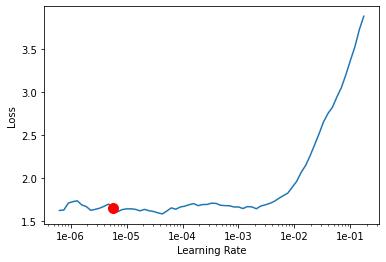

In [ ]:
if crossverify(data.valid_dl.y):
  #Loading the EfficientNet Model    
  model = EfficientNet.from_pretrained("efficientnet-b4")   
  top_5 = partial(top_k_accuracy, k=5)
  #Initializing the fastai learner 
  learneffb4 = Learner(data, model, metrics=[accuracy, top_5], callback_fns=ShowGraph).to_fp16()
  learneffb4.split( lambda m: (model._conv_head,) )
  #Finding the best learning rate using lr_find()
  learneffb4.lr_find()
  learneffb4.recorder.plot(suggestion=True)
else:
  print("Data Mismatch")

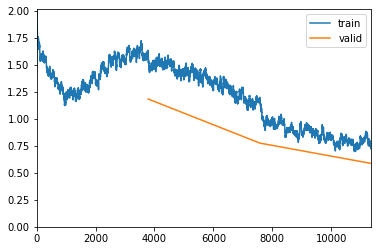

In [ ]:
lr = 4e-3
learneffb4.fit_one_cycle(3, max_lr=slice(lr))
learneffb4.save('/content/drive/MyDrive/food-effNetb4101-train-e3')

In [ ]:
#Creating the test data bunch 
test_data = (ImageList.from_df(df=test_df, path=path/'images', cols=1)
            .split_none()
            .label_from_df(cols=0)
            .transform(size=512)
            .databunch(bs=bs_effb4)
            .normalize(imagenet_stats))

top_5 = partial(top_k_accuracy, k=5)
model = EfficientNet.from_pretrained("efficientnet-b4")
learneffb4 = Learner(test_data, model, metrics=[accuracy, top_5]).to_fp16()
learneffb4.load('/content/drive/MyDrive/food-effNetb4101-train-e3')

In [ ]:
#Testaccuracy before cleaning 
learneffb4.validate(test_data.train_dl)

[0.40142354, tensor(0.8905), tensor(0.9818)]

In [ ]:
# Manual Cleaning using fastai widget 
from fastai.widgets import *

In [ ]:
#creating the databunch of the complete training set 
data_clean = (ImageList.from_df(df=train_df, path=path/'images', cols=1)
        .split_none()
        .label_from_df(cols=0)
        .transform(ds_tfms, size=512)
        .databunch())

In [ ]:
learn_effb4_cln = Learner(data_clean, model, metrics=[accuracy, top_5]).to_fp16()
learn_effb4_cln.load('/content/drive/MyDrive/food-effNetb4101-train-e3')

In [ ]:
ds, idxs = DatasetFormatter().from_toplosses(learn_effb4_cln)

In [ ]:
# manually removing some of the noise in dataset. 
ImageCleaner(ds, idxs, path)

Button(button_style='primary', description='Next Batch', layout=Layout(width='auto'), style=ButtonStyle())

In [ ]:
#storing the cleaned csv
!cp /root/.fastai/data/food-101/cleaned.csv /content/drive/MyDrive/cleaned_b4.csv

In [ ]:
#databunch after the manual cleaning 
data_afterclean = ImageDataBunch.from_csv(path, folder=".", valid_pct=0.2, csv_labels='/content/drive/MyDrive/cleaned_b4.csv',
                               ds_tfms=ds_tfms, bs=bs_effb4, size=img_size_effb4, num_workers=2).normalize(imagenet_stats)

learn_effb4 = Learner(data_afterclean, model, metrics=[accuracy, top_5], callback_fns=ShowGraph).to_fp16()
learn_effb4.load('/content/drive/MyDrive/food-effNetb4101-train-e3')

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 1.32E-06
Min loss divided by 10: 5.75E-05


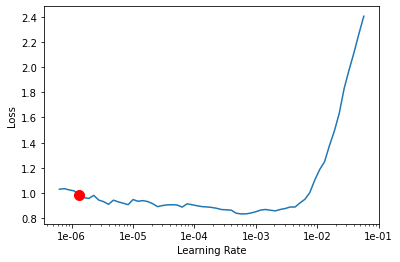

In [ ]:
learn_effb4.unfreeze()
learn_effb4.lr_find()
learn_effb4.recorder.plot(suggestion=True)

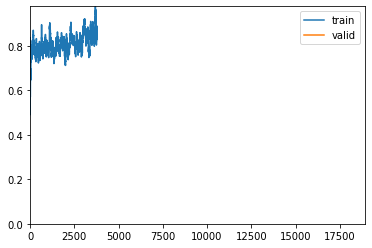

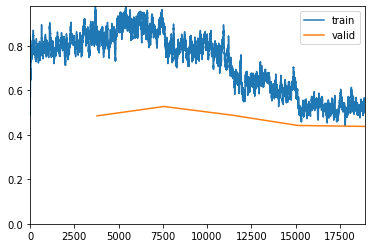

In [23]:
#retraining the model with cleaned dataset and new learning rate  
lr = 2e-4
learn_effb4.fit_one_cycle(5, max_lr=slice(lr))
learn_effb4.save('/content/drive/MyDrive/food-effNetb4101-train-ev3')

In [26]:
#Predicting the test accuracy with the clean dataset 
if crossverify(data.valid_dl.y):
  start= time.time()
  Y_valid_predict_effb4_mc = []
  for img in test_data.train_dl.x:
      tmp_predict = learn_effb4.predict(img)
      Y_valid_predict_effb4_mc.append(tmp_predict[1]) #predict will return three thensor values along with the probability for each category .We can 
  end = time.time()
  print('Time taken to predict for EfficientNetb3  :',{end - start})
else:
  print('Data Mismatch')

Time taken to predict for EfficientNetb3  : {1356.4562578201294}


In [27]:
#Evaluating the performance of test prediction 
evaluate_performance(test_data.train_dl.y,Y_valid_predict_effb4_mc)

              precision    recall  f1-score   support

           0       0.83      0.77      0.80       250
           1       0.91      0.92      0.92       250
           2       0.95      0.96      0.95       250
           3       0.97      0.95      0.96       250
           4       0.88      0.89      0.89       250
           5       0.88      0.84      0.86       250
           6       0.92      0.91      0.92       250
           7       0.96      0.96      0.96       250
           8       0.80      0.78      0.79       250
           9       0.81      0.90      0.85       250
          10       0.91      0.91      0.91       250
          11       0.92      0.96      0.94       250
          12       0.96      0.96      0.96       250
          13       0.89      0.94      0.92       250
          14       0.93      0.91      0.92       250
          15       0.88      0.83      0.86       250
          16       0.95      0.95      0.95       250
          17       0.84    

In [ ]:
log_preds, y = learn_effb4.TTA(ds_type=test_data.train_dl)
accuracy(log_preds, y)

In [32]:
#Prediction for the validation set 
if crossverify(data.valid_dl.y):
  start= time.time()
  Y_valid_predict_effb4_1 = []
  for img in data.valid_dl.x:
      tmp_predict = learn_effb4.predict(img)
      Y_valid_predict_effb4_1.append(tmp_predict[1]) #predict will return three thensor values along with the probability for each category .We can 
  end = time.time()
  print('Time taken to predict for EfficientNetb3  :',{end - start})
else:
  print('Data Mismatch')

Time taken to predict for EfficientNetb3  : {746.2798883914948}


In [33]:
#performance of validation set 
evaluate_performance(data.valid_dl.y,Y_valid_predict_effb4_1)

              precision    recall  f1-score   support

           0       0.93      0.85      0.88       149
           1       0.90      0.94      0.92       138
           2       0.96      0.98      0.97       150
           3       0.96      0.96      0.96       154
           4       0.92      0.94      0.93       141
           5       0.95      0.91      0.93       159
           6       0.90      0.96      0.93       133
           7       0.94      0.99      0.97       136
           8       0.88      0.90      0.89       164
           9       0.89      0.92      0.90       136
          10       0.92      0.93      0.92       143
          11       0.94      0.94      0.94       145
          12       0.96      0.95      0.96       157
          13       0.97      0.97      0.97       148
          14       0.94      0.88      0.91       149
          15       0.88      0.93      0.91       148
          16       0.98      0.99      0.99       167
          17       0.91    